# Graph Neural Networks (GNNs)

Graph Neural Networks (GNNs) have emerged as a powerful class of neural networks, designed to capture the complexity and relational information inherent in graph-structured data.

Unlike traditional neural networks, GNNs excel in scenarios where data points are interconnected, such as social networks, molecular structures, and transportation systems.

## Why GNNs?

Let's consider a scenario where you're planning a party and want to choose a seating arrangement such that everyone has the best time possible. A traditional Neural Network would consider each friend individually, possibly overlooking how they connect with others. This approach might lead to mismatched seating, where friends who’d enjoy each other’s company are separated.

On the other hand, Graph Neural Networks (GNNs) can look at the whole network of friendships, who knows whom, who shares interests, and who might enjoy meeting each other. A GNN will know to seat Donna next to Martha because they both know John Smith and have worked at UNIT. Everyone has a great time because the GNN understands the complex web of relationships and interactions!

One of the fundamental layers in deep learning is the Graph Convolutional Network (GCN) layer, which can be thought of as being similar in function to a convolutional layer in a Convolutional Neural Network (CNN).

In a CNN, the convolutional layer gathers and processes information from surrounding pixels, known as the “receptive field,” to create a condensed, lower-dimensional representation:
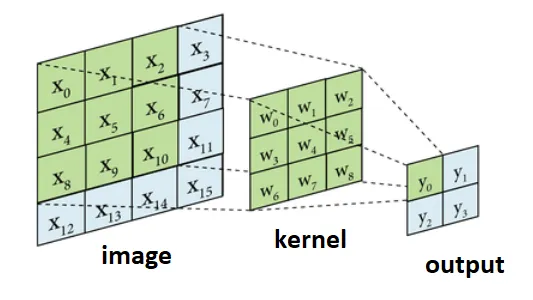

Source: https://medium.com/@thepyprogrammer/2d-image-convolution-with-numpy-with-a-handmade-sliding-window-view-946c4acb98b4


A GCN layer acts similarly, however in this case instead of neighbouring pixels, we aggregate information from neighbouring nodes in the graph (as well as the node itself):

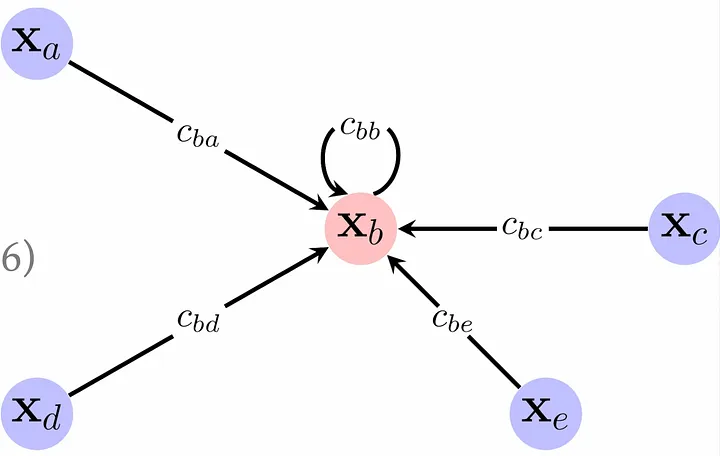

## Deriving the equation for Graph Convolutional Networks!!!

The input to a GNN is a graph! We can represent this as a (design) matrix of node features and an Adjacency Matrix comprising of 1s indicating connections between nodes and 0s otherwise:
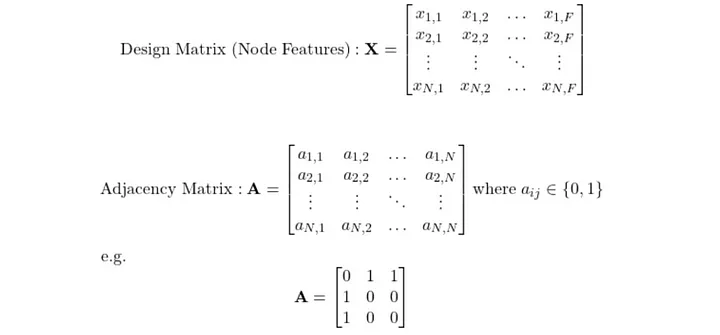

So this example adjacency matrix would be for the graph:

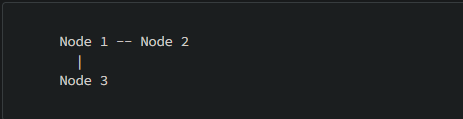

When we perform the operation of multiplying matrix A (the adjacency matrix) by matrix X (the feature matrix), the result is essentially the aggregation of the features of all neighboring nodes for each individual node.

To illustrate, let's consider a specific node 'i'. The multiplication operation effectively sums up the features of all neighboring nodes 'j' connected to node 'i'. This operation allows us to capture the local neighborhood information for each node in the graph


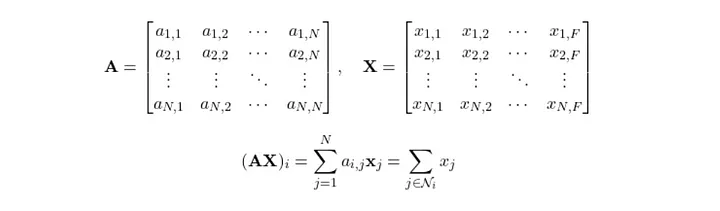

Indeed, it's crucial to consider the feature vector of the node itself along with its neighbors. To incorporate this, we can modify the adjacency matrix by adding an identity matrix to it. This operation effectively adds a "self-loop" to each node, ensuring that the node's own features are included in the aggregation. 

Mathematically, this is represented as follows:

![Adjacency Matrix with Identity](https://miro.medium.com/v2/resize:fit:720/format:webp/1*s6Gi2m-jd5PFL0wfgLalag.png)

In this modified adjacency matrix, the diagonal elements are set to 1, indicating a self-loop for each node. This ensures that when we multiply this matrix with the feature matrix, the feature vector of each node is included in the sum.

Such that:

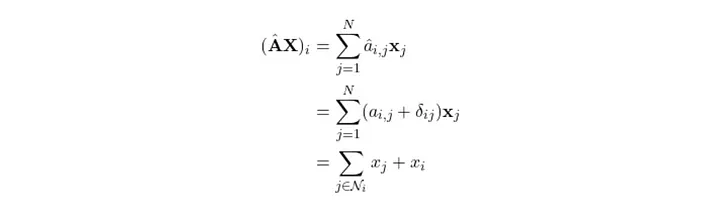

Indeed, normalization is a crucial step when dealing with Graph Neural Networks. The reason is that some nodes may have many neighbors, leading to a large sum of feature vectors, while others may have only a few, resulting in a smaller sum.

To address this, we can normalize the sum by the degree of each node, which is the number of neighbors it has. This can be achieved by creating a diagonal degree matrix D, where each diagonal entry corresponds to the degree of a node.

![Degree Matrix](https://miro.medium.com/v2/resize:fit:720/format:webp/1*fPMpC6yVCZhhQ9c4-AmVNA.png)

In this matrix, each diagonal entry D[i][i] represents the degree of node i. By using this matrix, we can ensure that the feature aggregation step takes into account the degree of each node, preventing nodes with more neighbors from dominating the feature aggregation process. This normalization step is crucial for the proper functioning of Graph Neural Networks. 

In the upcoming sections of the notebook, we will see how this degree matrix is used in the implementation of a Graph Neural Network.

And so the following would normalise our equation with repsect to colimns or rows.
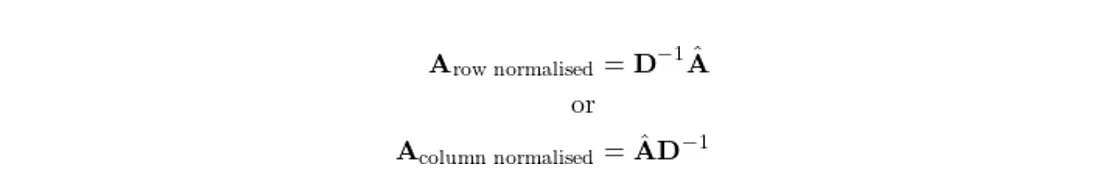

Indeed, both row normalization and column normalization have their unique benefits when dealing with Graph Neural Networks. 

Row normalization effectively calculates the mean value of the neighbors, providing an average feature representation. On the other hand, column normalization considers the degree of the neighbors, giving more weight to nodes with fewer connections.

To leverage the advantages of both, we can use symmetric normalization. This method combines row and column normalization, ensuring that both the average features and the degree of the nodes are taken into account.

Here's the mathematical representation of symmetric normalization:

![Symmetric Normalization](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*O-n-8VWwG6Xcg9fh2zT1kg.png)

In the upcoming sections of the notebook, we will see how this symmetric normalization is implemented in the context of a Graph Neural Network.

Now, we just need some parameters for our machine learning model to learn, hopefully it makes sense to just pop a weight matrix in there like we do with linear regression etc.!

![Symetric Normalization](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*gjueOna7ra-VOrgAvZ4bww.png)

Finally


![Relu added](https://miro.medium.com/v2/resize:fit:720/format:webp/1*mYfqrZ47I1WEYX0ibCIy9w.png)



## PyTorch Implementation

In the following sections, we will provide a PyTorch implementation of a GNN. This will include the mathematical proof behind the implementation, the actual PyTorch code, and some additional resources for further learning.

Stay tuned for the upcoming sections where we dive deeper into the world of Graph Neural Networks!

(Note: The actual implementation code will be provided in the following sections of the notebook.)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    """
        GCN layer

        Args:
            input_dim (int): Dimension of the input
            output_dim (int): Dimension of the output (a softmax distribution)
            A (torch.Tensor): 2D adjacency matrix
    """

    def __init__(self, input_dim: int, output_dim: int, A: torch.Tensor):
        super(GCNLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A

        # A_hat = A + I
        self.A_hat = self.A + torch.eye(self.A.size(0))

        # Create diagonal degree matrix D
        self.ones = torch.ones(input_dim, input_dim)
        self.D = torch.matmul(self.A.float(), self.ones.float())

        # Extract the diagonal elements
        self.D = torch.diag(self.D)

        # Create a new tensor with the diagonal elements and zeros elsewhere
        self.D = torch.diag_embed(self.D)
        
        # Create D^{-1/2}
        self.D_neg_sqrt = torch.diag_embed(torch.diag(torch.pow(self.D, -0.5)))
        
        # Initialise the weight matrix as a parameter
        self.W = nn.Parameter(torch.rand(input_dim, output_dim))

    def forward(self, X: torch.Tensor):

        # D^-1/2 * (A_hat * D^-1/2)
        support_1 = torch.matmul(self.D_neg_sqrt, torch.matmul(self.A_hat, self.D_neg_sqrt))
        
        # (D^-1/2 * A_hat * D^-1/2) * (X * W)
        support_2 = torch.matmul(support_1, torch.matmul(X, self.W))
        
        # ReLU(D^-1/2 * A_hat * D^-1/2 * X * W)
        H = F.relu(support_2)

        return H

if __name__ == "__main__":

    # Example Usage
    input_dim = 3  # Assuming the input dimension is 3
    output_dim = 2  # Assuming the output dimension is 2

    # Example adjacency matrix
    A = torch.tensor([[1., 0., 0.],
                      [0., 1., 1.],
                      [0., 1., 1.]])  

    # Create the GCN Layer
    gcn_layer = GCNLayer(input_dim, output_dim, A)

    # Example input feature matrix
    X = torch.tensor([[1., 2., 3.],
                      [4., 5., 6.],
                      [7., 8., 9.]])

    # Forward pass
    output = gcn_layer(X)
    
    print(output)
    # tensor([[ 6.3438,  5.8004],
    #         [13.3558, 13.7459],
    #         [15.5052, 16.0948]], grad_fn=<ReluBackward0>)

tensor([[ 1.6552,  7.6796],
        [ 3.7179, 17.8898],
        [ 4.3370, 20.9223]], grad_fn=<ReluBackward0>)
